In [53]:
import numpy as np
import matplotlib.pyplot as plt 

In [54]:
#constants of nature

mu0 = 4 * np.pi * 1e-7
e0 = 8.85e-12
c = np.sqrt(1 / (mu0 * e0))
k = 1 / (4 * np.pi * e0)
print("the speed of light is:", c)

dt = 0.0005

the speed of light is: 299863380.46612763


In [55]:
t0 = 0
t1 = 40
timesteps = np.arange(t0, t1, dt)

In [93]:
def external_force_func(E0,omega,timesteps):
    return (E0 * np.sin(omega * timesteps))

E0 = 0.02
omega = np.sqrt(2) 

external_force_arr = external_force_func(E0,omega,timesteps)
    

In [94]:
class Particle:
    
    def __init__(self, mass=1, charge=1, pos=np.array([0.0,0.0,0.0]), vel=np.array([0.0,0.0,0.0]), acc=np.array([0.0,0.0,0.0])):
        self.mass = mass
        self.charge = charge
        self.pos = pos
        self.vel = vel
        self.acc = acc

class Dipole:
    
    def __init__(self, timesteps, distance=1, charge=1):
        self.distance = distance
        self.charge = charge
        self.mass = 1
        self.particle1 = Particle(mass=self.mass, charge=self.charge, pos=np.array([-distance/2, 0,0]))
        self.particle2 = Particle(mass=self.mass, charge=-self.charge, pos=np.array([distance/2, 0,0]))
        self.dipole_moment = self.charge * np.array([self.distance, 0, 0])
        self.force = 0
        self.timesteps = timesteps
        self.pos1 = np.zeros(self.timesteps.shape)
        self.pos2 = np.zeros(self.timesteps.shape)
        self.k = 1
        print(self.pos1.shape)
        
    def update(self, external_force):
        r = self.particle2.pos - self.particle1.pos
        
        spring_force = self.k * (np.linalg.norm(r) - self.distance) * (r / np.linalg.norm(r))
        force = spring_force + external_force * self.charge
        
        self.particle1.acc = force / self.particle1.mass
        self.particle2.acc = -force / self.particle2.mass
        self.particle1.vel = self.particle1.vel + self.particle1.acc * dt
        self.particle2.vel = self.particle2.vel + self.particle2.acc * dt
        
        self.particle1.pos += self.particle1.vel * dt
        self.particle2.pos += self.particle2.vel * dt
        
#         print(self.particle1.vel + self.particle1.acc * dt)

#         print(self.particle1.pos)
#         print(self.particle2.pos)
        
    def calc_trajectory(self):
        
        for i, time in enumerate(self.timesteps):
            self.pos1[i] = self.particle1.pos[0]
            self.pos2[i] = self.particle2.pos[0]
            
#             print(i)
#             print(time)
            
            external_force = np.array([external_force_arr[i], 0, 0])
            
            self.update(external_force)
            
        return self.pos1, self.pos2
        

(80000,)
0.7827433527256835


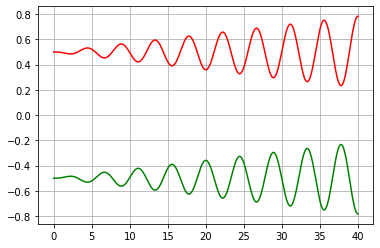

In [97]:
dipole = Dipole(timesteps)

pos1, pos2 = dipole.calc_trajectory()
# print(timesteps.shape)
# print(pos1)

plt.plot(timesteps, pos1, 'g')
plt.plot(timesteps, pos2, 'r')
plt.grid()

print(np.amax(pos2))

(80000,)
(80000,)
(80000,)
(80000,)
(80000,)
(80000,)
(80000,)
(80000,)
(80000,)
(80000,)
(80000,)
(80000,)
(80000,)
(80000,)
(80000,)


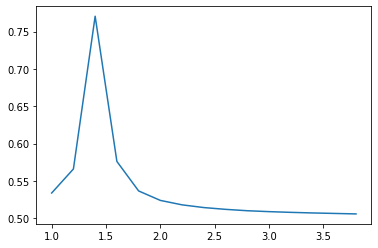

In [100]:
omega_arr = np.arange(1,4,0.2)
E0 = 0.02
plot_store = np.zeros(np.shape(omega_arr))
for i in range(np.size(omega_arr)):
    external_force_arr = external_force_func(E0,omega_arr[i],timesteps)
    dipole_arr = Dipole(timesteps)
    posA,posB = dipole_arr.calc_trajectory()    
    plot_store[i] = np.amax(posB)
    #print(np.amax(posB))
plt.plot(omega_arr,plot_store)

[-1.0, -1.0]


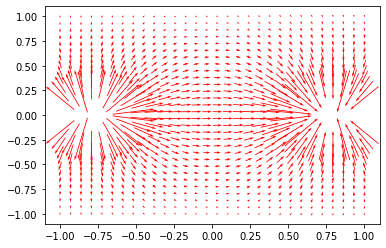

In [72]:
def calc_electric_field(dipole, point):
    dif1 = point - dipole.particle1.pos
    dif2 = point - dipole.particle2.pos
    
    r_mag1 = np.linalg.norm(dif1)
    r_mag2 = np.linalg.norm(dif2)
    
    Ex = dipole.charge * (dif1[0]*r_mag1**-3 - dif2[0]*r_mag2**-3)
    Ey = dipole.charge * (dif1[1]*r_mag1**-3 - dif2[1]*r_mag2**-3)
    Ez = dipole.charge * (dif1[2]*r_mag1**-3 - dif2[2]*r_mag2**-3)
    
    return np.array([Ex, Ey, Ez])

E = calc_electric_field(dipole, [x, y, 0])

magEfield = np.sqrt(E[0]**2 + E[1]**2 + E[2]**2)
maxMagEfield = np.max(magEfield)

mask = np.where(magEfield < maxMagEfield * 0.02)

Nsteps = 30
grid_min = -1
grid_max = 1
# print(np.array([x[0], y[0]]))
print([x[0][0], y[0][0]])

x, y = np.meshgrid(np.linspace(grid_min, grid_max, Nsteps),
                      np.linspace(grid_min, grid_max, Nsteps))

Qplot = plt.quiver(x[mask], y[mask], 
                   E[0][mask], E[1][mask], 
                   units='inches',pivot='mid',color='r', scale=25)